In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd
from scipy.stats import beta, t, norm

%matplotlib inline

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
n = 500

In [24]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_normal(n)
y = 3*(x-5)+error
y=np.float32(y)

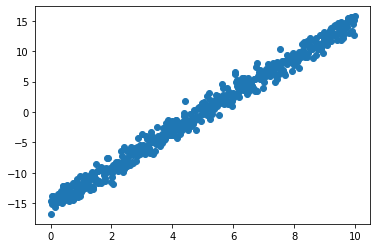

In [25]:
plt.scatter(x,y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [27]:
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [28]:
X = torch.FloatTensor(X).to(device)
Y = torch.FloatTensor(Y).to(device)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [29]:
trainloader = DataLoader(X_train)
testloader = DataLoader(X_test)

In [30]:
class Model(nn.Module):
  '''
  one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: 
  (i) number of hidden layers equals one; and 
  (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
  '''
  def __init__(self, in_features=1, h1=10, h2=10, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)    # input layer
    self.fc2 = nn.Linear(h1, h2)            # hidden layer
    self.out = nn.Linear(h2, out_features)  # output layer
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

  def training_step(self, x, y):
    pass

  def validation_step(self, x, y):
    pass
  
  def validation_epoch_end(self, outputs):
    pass
  
  def epoch_end(self, epoch, result):
    pass

In [31]:

class ModelTrainer():
  def fit(self, epochs=500, learning_rate=0.01, model=Model(),X_train=X_train,y_train=y_train,criterion = nn.MSELoss(), opt_func=torch.optim.Adam,seed=torch.manual_seed(4)):
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

  def _evaluate(self, model, X_test, y_test,criterion = nn.MSELoss()):
    with torch.no_grad():
      y_val = model.forward(X_test)
      loss = criterion(y_val, y_test)
    return [loss,y_val]



In [32]:
model = Model(h1=3,h2=29).to(device)
model_trainer = ModelTrainer()
model_trainer.fit(500,0.01,model, X_train, y_train)
y_val = model_trainer._evaluate(model,X,Y)[1]

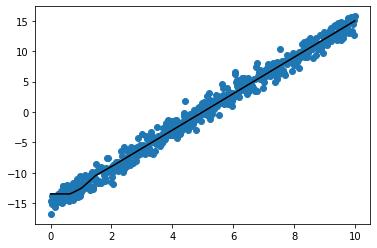

In [33]:
plt.plot(X.to('cpu'),y_val.to('cpu'),'k-',label='line1')
plt.scatter(X.to('cpu'),Y.to('cpu'),label='line2')

In [34]:
P,alpha = 0.99,0.05
for i in range(1,int(n/2)+1):
  if beta.cdf(P,n-2*i+1,2*i)>alpha: break
r = i-1 if i>1 else 1
B=500
x = np.float32(np.linspace(0,10,n))
y_true = 3*np.cos(x)-5*np.power((x/5),2)
interval = []
for i in range(B):
  x = np.float32(np.linspace(0,10,n))
  error = np.random.standard_normal(n)
  #error = np.random.standard_t(2,n)
  y = 3*np.cos(x)-5*np.power((x/5),2)  +error
  x = torch.FloatTensor(x.reshape(-1,1)).to(device)
  y = torch.FloatTensor(y.reshape(-1,1)).to(device)
  model = Model(h1=8,h2=29).to(device)
  model_trainer = ModelTrainer()
  model_trainer.fit(500,0.01,model, x, y)
  y_val = model_trainer._evaluate(model,x,y)[1]
  res =  y_val - y
  res = [res.to('cpu')[i] for i in range(n)]
  res.sort()
  L = res[r-1]
  U = res[n-r]
  interval_c = []
  for j in range(n):
    #interval_c.append(t.cdf((y_val[j] + U[0]).to('cpu'),df=2,loc=y_true[j])- t.cdf((y_val[j] + L[0]).to('cpu'),df=2,loc=y_true[j]))
    interval_c.append(norm.cdf((y_val[j] + U[0]).to('cpu'),loc=y_true[j])- norm.cdf((y_val[j] + L[0]).to('cpu'),loc=y_true[j]))
  interval.append(interval_c)
a=(pd.DataFrame(interval)>P).mean(axis=0)
a.to_csv('9599_500quadcaseTI.csv')
print(sum((pd.DataFrame(interval)>P).sum(axis=0))/pd.DataFrame(interval).size , 'is 95/99 coverage probability for sample size 500')


0.901896 is 95/99 coverage probability for sample size 500


In [18]:
from google.colab import files
files.download('9599_500quadcaseTI.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 9095_500lincaseTI.csv to 9095_500lincaseTI.csv
Saving 9595_500lincaseTI.csv to 9595_500lincaseTI.csv
Saving 9599_500lincaseTI.csv to 9599_500lincaseTI.csv


In [35]:
#cov9095 = pd.read_csv('9095_500lincaseTI.csv')  
#cov9595 = pd.read_csv('9595_500lincaseTI.csv')
cov9995 = pd.read_csv('9599_500quadcaseTI.csv')

Text(0.5, 1.0, 'Neural Network Performance')

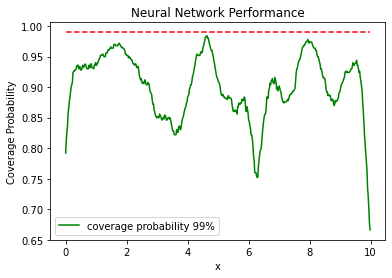

In [36]:
#plt.plot(cov9095.iloc[:,0]*0.02,cov9095.iloc[:,1],'k-',label='coverage probability 90%',color='blue')
#plt.plot(cov9095.iloc[:,0]*0.02,[0.90]*500,'k--',color='red',label='nominal confidence level')
#plt.plot(cov9595.iloc[:,0]*0.02,cov9595.iloc[:,1],'k-',label='coverage probability 95%')
#plt.plot(cov9595.iloc[:,0]*0.02,[0.95]*500,'k--',color='red')
plt.plot(cov9995.iloc[:,0]*0.02,cov9995.iloc[:,1],'k-',color='green',label='coverage probability 99%')
plt.plot(cov9995.iloc[:,0]*0.02,[0.99]*500,'k--',color='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("Coverage Probability")
plt.title('Neural Network Performance')